<center><h1>Saloni_Fnu_HW5</h1></center>
<br>
<br>

Name: Fnu Saloni
<br>
Github Username: fnusaloni
<br>
USC ID: 3175644840 

## 1. Decision Trees as Interpretable Models

Import packages

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import _tree
from sklearn.model_selection import train_test_split, GridSearchCV
import math
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor


### (a) Obtain Data

Get the Accute Inamations Data Set

In [85]:
# setting the path to the data file
location = '../data/diagnosis.data'

# opening the file 
# reading all lines from the file
with open(location, 'r', encoding='utf-16') as fl:
    lines = fl.readlines()

dataCol = [line.strip().split('\t') for line in lines]

# creating a dataframe with specified column names
dataSet = pd.DataFrame(dataCol, columns=['temperature', 'nausea', 'lumbar-pain', 'urine-pushing', 'micturition-pains', 'burning-urethra', 'bladder-inflammation', 'nephritis'])

# displaying the dataframe
dataSet


,temperature,nausea,lumbar-pain,urine-pushing,micturition-pains,burning-urethra,bladder-inflammation,nephritis
0,"35,5",no,yes,no,no,no,no,no
1,"35,9",no,no,yes,yes,yes,yes,no
2,"35,9",no,yes,no,no,no,no,no
3,"36,0",no,no,yes,yes,yes,yes,no
4,"36,0",no,yes,no,no,no,no,no
...,...,...,...,...,...,...,...,...
115,"41,4",no,yes,yes,no,yes,no,yes
116,"41,5",no,no,no,no,no,no,no
117,"41,5",yes,yes,no,yes,no,no,yes
118,"41,5",no,yes,yes,no,yes,no,yes


### (b) Build a decision tree

In [87]:
# defining a function to train and plot a decision tree
def train_and_plot_tree(X, Y):
    
    decTree = DecisionTreeClassifier()
    
    # fitting the model to the input features and target
    decTree.fit(X, Y)
    
    plt.figure(figsize=(10, 10))
    
    plot_tree(decTree, feature_names=X.columns.tolist(), filled=True)
    
    plt.show()
    return decTree


In [88]:
# defining a function to split the input and output from a dataframe
def split_input_output(df, numLab=1):
    
    # selecting all columns except the last two as feature columns
    featCol = df.columns[:-2]
    
    if numLab == 1:
        # selecting the first six columns as input features
        X_train = df.iloc[:, :6]

        Y_train = df.iloc[:, 6:].astype("int64")
    
    else:
        X_train = df[featCol]
        
        Y_train = df[df.columns[-2:]]
    
    # returning the input and output dataframes
    return X_train, Y_train


In [89]:
# defining a function to transform the dataset
def transform_data(df):
    
    # converting temperature values to float by replacing commas with dots
    df['temperature'] = df['temperature'].str.replace(',', '.').astype(float)

    # creating a label encoder instance
    encoder = LabelEncoder()
    
    for col in df.columns[1:]:
        df[col] = encoder.fit_transform(df[col])
    
    return df


In [90]:
# defining a function to read the dataset from a given file path
def read_dataset(fl_location):
    
    # assigning column names to the dataset
    colName = ['temperature', 'nausea', 'lumbar-pain', 'urine-pushing', 'micturition-pains', 'burning-urethra', 'bladder-inflammation', 'nephritis']
    
    dataSet = pd.read_csv(fl_location, encoding='utf-16', sep='\t', names=colName)
    
    # returning the loaded dataframe
    return dataSet

location = '../data/diagnosis.data'

# loading the original dataset using the defined function
orgData = read_dataset(location)

# transforming the dataset using preprocessing
forData = transform_data(orgData)

forData

,temperature,nausea,lumbar-pain,urine-pushing,micturition-pains,burning-urethra,bladder-inflammation,nephritis
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


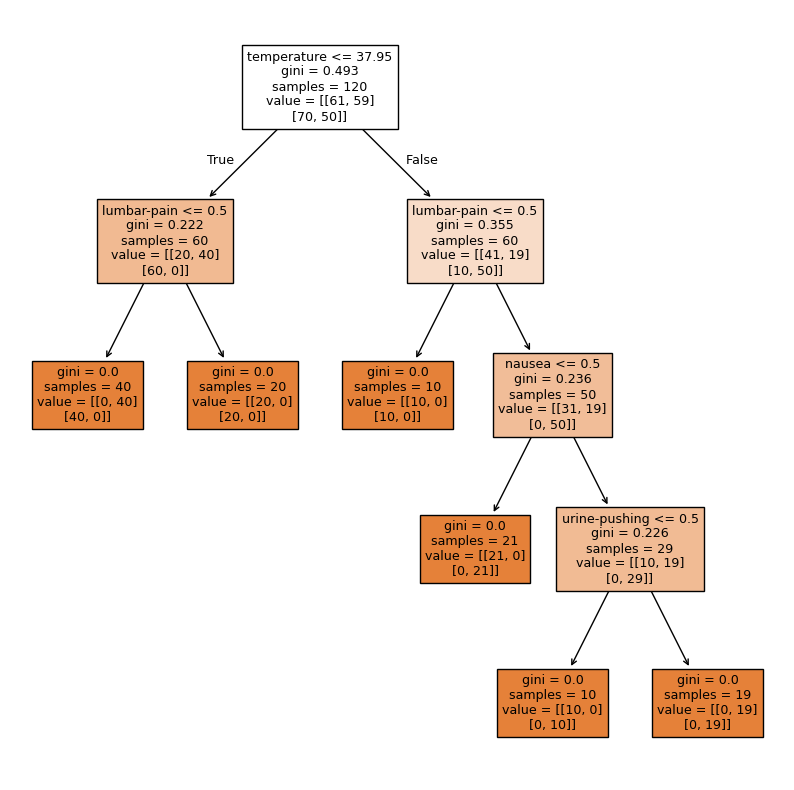

In [91]:
# splitting the transformed data into input features and target labels
X_train, Y_train = split_input_output(forData)

# training the decision tree model and plotting it
decTreeMod = train_and_plot_tree(X_train, Y_train)


### (c) Convert the decision rules

In [93]:
# defining a function to convert a decision tree into a set of rules
def iterative_tree_to_code(model, feature_names):
    
    # accessing the internal tree structure
    tree_structure = model.tree_
    
    node_features = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined"
        for i in tree_structure.feature
    ]
    
    # initializing the list of rule lines
    rule_lines = []
    rule_lines.append(f"def tree({', '.join(feature_names)}):")
    
    # initializing the stack with the root node
    stack = [(0, 1, None)]

    # iterating over the tree using a stack
    while stack:
        node_id, depth, parent_cond = stack.pop()
        indent = "  " * depth
        
        if tree_structure.feature[node_id] != _tree.TREE_UNDEFINED:
            feature = node_features[node_id]
            threshold = tree_structure.threshold[node_id]
            
            rule_lines.append(f"{indent}if {feature} <= {threshold:.5f}:")
            
            stack.append((tree_structure.children_right[node_id], depth + 1, f"if {feature} > {threshold:.5f}"))
            stack.append((tree_structure.children_left[node_id], depth + 1, None))
        
        else:
            value = tree_structure.value[node_id]
            rule_lines.append(f"{indent}return {value}")
            
            if stack and stack[-1][2] is not None:
                sibling_node, sibling_depth, sibling_cond = stack.pop()
                sibling_indent = "  " * (sibling_depth - 1)
                rule_lines.append(f"{sibling_indent}else:  # {sibling_cond}")
                stack.append((sibling_node, sibling_depth, None))

    return "\n".join(rule_lines)

# generating and printing the decision rules from the trained tree model
tree_code = iterative_tree_to_code(decTreeMod, feature_names=X_train.columns.tolist())
print(tree_code)


def tree(temperature, nausea, lumbar-pain, urine-pushing, micturition-pains, burning-urethra):
  if temperature <= 37.95000:
    if lumbar-pain <= 0.50000:
      return [[0. 1.]
 [1. 0.]]
    else:  # if lumbar-pain > 0.50000
      return [[1. 0.]
 [1. 0.]]
  else:  # if temperature > 37.95000
    if lumbar-pain <= 0.50000:
      return [[1. 0.]
 [1. 0.]]
    else:  # if lumbar-pain > 0.50000
      if nausea <= 0.50000:
        return [[1. 0.]
 [0. 1.]]
      else:  # if nausea > 0.50000
        if urine-pushing <= 0.50000:
          return [[1. 0.]
 [0. 1.]]
        else:  # if urine-pushing > 0.50000
          return [[0. 1.]
 [0. 1.]]


### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

Grid Search Results:
          alpha  mean_accuracy  std_accuracy
0  0.0000000000   1.0000000000  0.0000000000
1  0.0508130081   0.8421052632  0.0815364915
2  0.0803467729   0.7700000000  0.0730726501
3  0.1099290780   0.6142105263  0.1093369592
4  0.2026727856   0.3873684211  0.1499621374

Selected alpha for minimal pruned tree: 0.0508130081300813
Training Accuracy: 0.8333
Test Accuracy: 0.8750


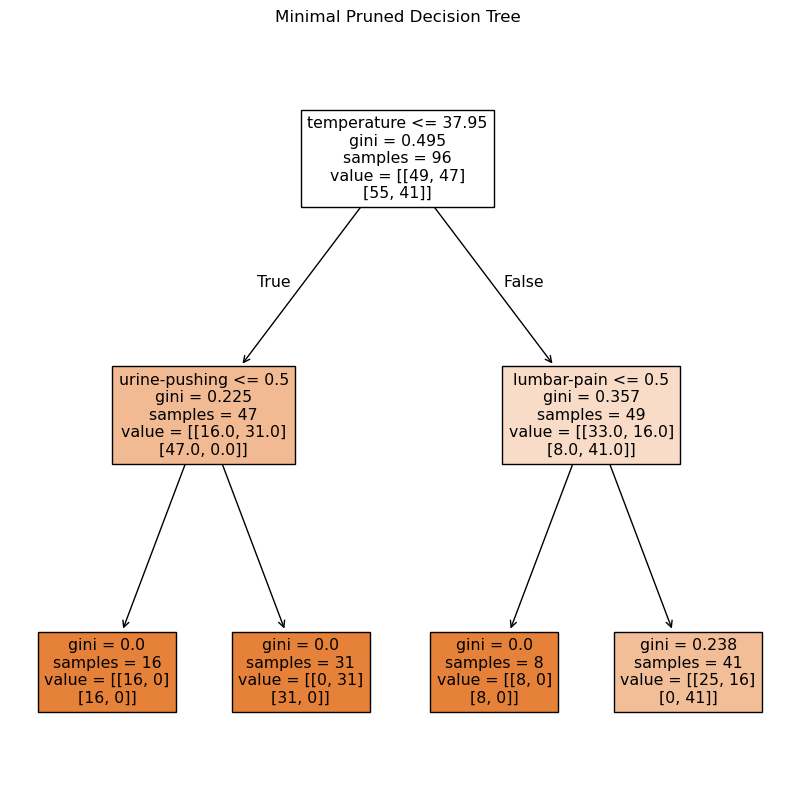

Decision Tree Rules:
 |--- temperature <= 37.95
|   |--- urine-pushing <= 0.50
|   |   |--- class: 0
|   |--- urine-pushing >  0.50
|   |   |--- class: 1
|--- temperature >  37.95
|   |--- lumbar-pain <= 0.50
|   |   |--- class: 0
|   |--- lumbar-pain >  0.50
|   |   |--- class: 0



In [95]:



# splitting the dataset into input features and target labels
X_full, Y_full = split_input_output(forData)


X_train, X_test, Y_train, Y_test = train_test_split(X_full, Y_full, test_size=0.2, random_state=42)


priModel = DecisionTreeClassifier(random_state=42)
priModel.fit(X_train, Y_train)
sparsePath = priModel.cost_complexity_pruning_path(X_train, Y_train)
alphaOpt = sparsePath.ccp_alphas

gridOpt = {"ccp_alpha": alphaOpt}
gridCvMod = GridSearchCV(DecisionTreeClassifier(random_state=42), gridOpt, cv=5, scoring="accuracy")
gridCvMod.fit(X_train, Y_train)

# creating a dataframe to store alpha values and their corresponding accuracies
outputs = pd.DataFrame({
    "alpha": gridCvMod.cv_results_["param_ccp_alpha"],
    "mean_accuracy": gridCvMod.cv_results_["mean_test_score"],
    "std_accuracy": gridCvMod.cv_results_["std_test_score"]
})

# sorting the results based on mean accuracy
outputs = outputs.sort_values(by="mean_accuracy", ascending=False)
print("Grid Search Results:")
print(outputs)

choosenAlpha = outputs.iloc[1]["alpha"]
print(f"\nSelected alpha for minimal pruned tree: {choosenAlpha}")

# training a pruned decision tree using the selected alpha
simpleTree = DecisionTreeClassifier(random_state=42, ccp_alpha=choosenAlpha)
simpleTree.fit(X_train, Y_train)

# evaluating the pruned tree on training and test data
accTrain = simpleTree.score(X_train, Y_train)
accTest = simpleTree.score(X_test, Y_test)
print(f"Training Accuracy: {accTrain:.4f}")
print(f"Test Accuracy: {accTest:.4f}")

# plotting the pruned decision tree
plt.figure(figsize=(10, 10))
plot_tree(simpleTree, feature_names=X_train.columns.tolist(), filled=True)
plt.title("Minimal Pruned Decision Tree")
plt.show()

# generating and printing the decision rules in text format
decTreeText = export_text(simpleTree, feature_names=X_train.columns.tolist())
print("Decision Tree Rules:\n", decTreeText)


##  The LASSO and Boosting for Regression

### (a) Obtain Data

In [98]:

# assigning the file path and column names for the dataset
loc = '../data/communities.data'
nameCol = ['state', 'county', 'community', 'communityname', 'fold', 'population',
           'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp',
           'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban',
           'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst',
           'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap',
           'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov',
           'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy',
           'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf',
           'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam',
           'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids',
           'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5',
           'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8',
           'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam',
           'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous',
           'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant',
           'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt',
           'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal', 'OwnOccHiQuart',
           'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent', 'MedRentPctHousInc',
           'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet',
           'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85', 'PctSameCity85',
           'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
           'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic',
           'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp',
           'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
           'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars',
           'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn',
           'PolicBudgPerPop', 'ViolentCrimesPerPop']

dataCol = pd.read_csv(loc, names=nameCol, na_values="?")

# calculating the number of test samples based on training size
testNo = dataCol.shape[0] - 1495

# splitting the dataset into training and test sets without shuffling
trainData, testData = train_test_split(dataCol, test_size=testNo, shuffle=False)

# displaying the first few rows of the training set
trainData


,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,6,NaN,NaN,Hillsboroughtown,8,0.00,0.59,0.01,0.69,1.00,...,0.02,0.14,0.22,NaN,NaN,NaN,NaN,0.00,NaN,0.03
1491,6,NaN,NaN,Orangecity,8,0.16,0.62,0.03,0.74,0.48,...,0.07,0.40,0.14,0.07,0.05,0.85,0.5,0.61,0.19,0.20
1492,13,NaN,NaN,Waycrosscity,8,0.01,0.36,0.95,0.24,0.03,...,0.03,0.12,0.01,NaN,NaN,NaN,NaN,0.00,NaN,0.30
1493,39,85.0,49056.0,Mentorcity,8,0.06,0.53,0.01,0.98,0.05,...,0.08,0.15,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [99]:
testData

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
1495,6,NaN,NaN,MillValleycity,8,0.00,0.20,0.03,0.91,0.23,...,0.01,0.23,0.73,NaN,NaN,NaN,NaN,0.00,NaN,0.12
1496,48,NaN,NaN,LiveOakcity,8,0.00,0.55,0.13,0.78,0.15,...,0.01,0.18,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.11
1497,35,NaN,NaN,Portalescity,8,0.00,0.52,0.04,0.59,0.05,...,0.01,0.18,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.12
1498,42,17.0,25112.0,Fallstownship,8,0.04,0.51,0.07,0.92,0.09,...,0.06,0.13,0.16,NaN,NaN,NaN,NaN,0.00,NaN,0.06
1499,51,683.0,48952.0,Manassascity,8,0.03,0.59,0.20,0.75,0.19,...,0.03,0.23,0.06,NaN,NaN,NaN,NaN,0.00,NaN,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


### (b) Missing values

In [101]:


# removing nonpredictive columns
remCol = ['state', 'county', 'community', 'communityname', 'fold']
trainCol = trainData.drop(columns=remCol, errors='ignore')
testCol = testData.drop(columns=remCol, errors='ignore')

# converting the dataframes to numpy arrays for manual imputation
trainNumpy = trainCol.to_numpy().copy()
testNumpy = testCol.to_numpy().copy()

# getting the total number of columns in the training data
colNum = trainNumpy.shape[1]

# computing the mean of each column in the training data while ignoring missing values
trainMean = np.empty(colNum)
for col in range(colNum):
    trainMean[col] = np.nanmean(trainNumpy[:, col])

for col in range(colNum):
    missVal = np.isnan(trainNumpy[:, col])
    trainNumpy[missVal, col] = trainMean[col]

for col in range(colNum):
    missVal = np.isnan(testNumpy[:, col])
    testNumpy[missVal, col] = trainMean[col]

# converting the imputed numpy arrays back to pandas dataframes
trainFrame = pd.DataFrame(trainNumpy, columns=trainCol.columns)
testFrame = pd.DataFrame(testNumpy, columns=testCol.columns)

# concatenating the training and test dataframes into a combined dataframe
combineFrame = pd.concat([trainFrame, testFrame], ignore_index=True)

trainFrame


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.0600000000,0.0400000000,0.9000000000,0.5000000000,0.32,0.1400000000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.02,0.14,0.22,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.03
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.07,0.40,0.14,0.0700000000,0.0500000000,0.8500000000,0.5000000000,0.61,0.1900000000,0.20
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.03,0.12,0.01,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.30
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.15,0.02,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.03


In [102]:
testFrame

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.01,0.23,0.73,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.12
1,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.01,0.18,0.02,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.11
2,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.01,0.18,0.00,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.12
3,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.06,0.13,0.16,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.06
4,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.03,0.23,0.06,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.09
495,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.1639748954,0.0805020921,0.7130543933,0.4518828452,0.00,0.1907531381,0.45
496,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.0800000000,0.0600000000,0.7800000000,0.0000000000,0.91,0.2800000000,0.23
497,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.0200000000,0.0200000000,0.7900000000,0.0000000000,0.22,0.1800000000,0.19


### (c) Plot a correlation matrix

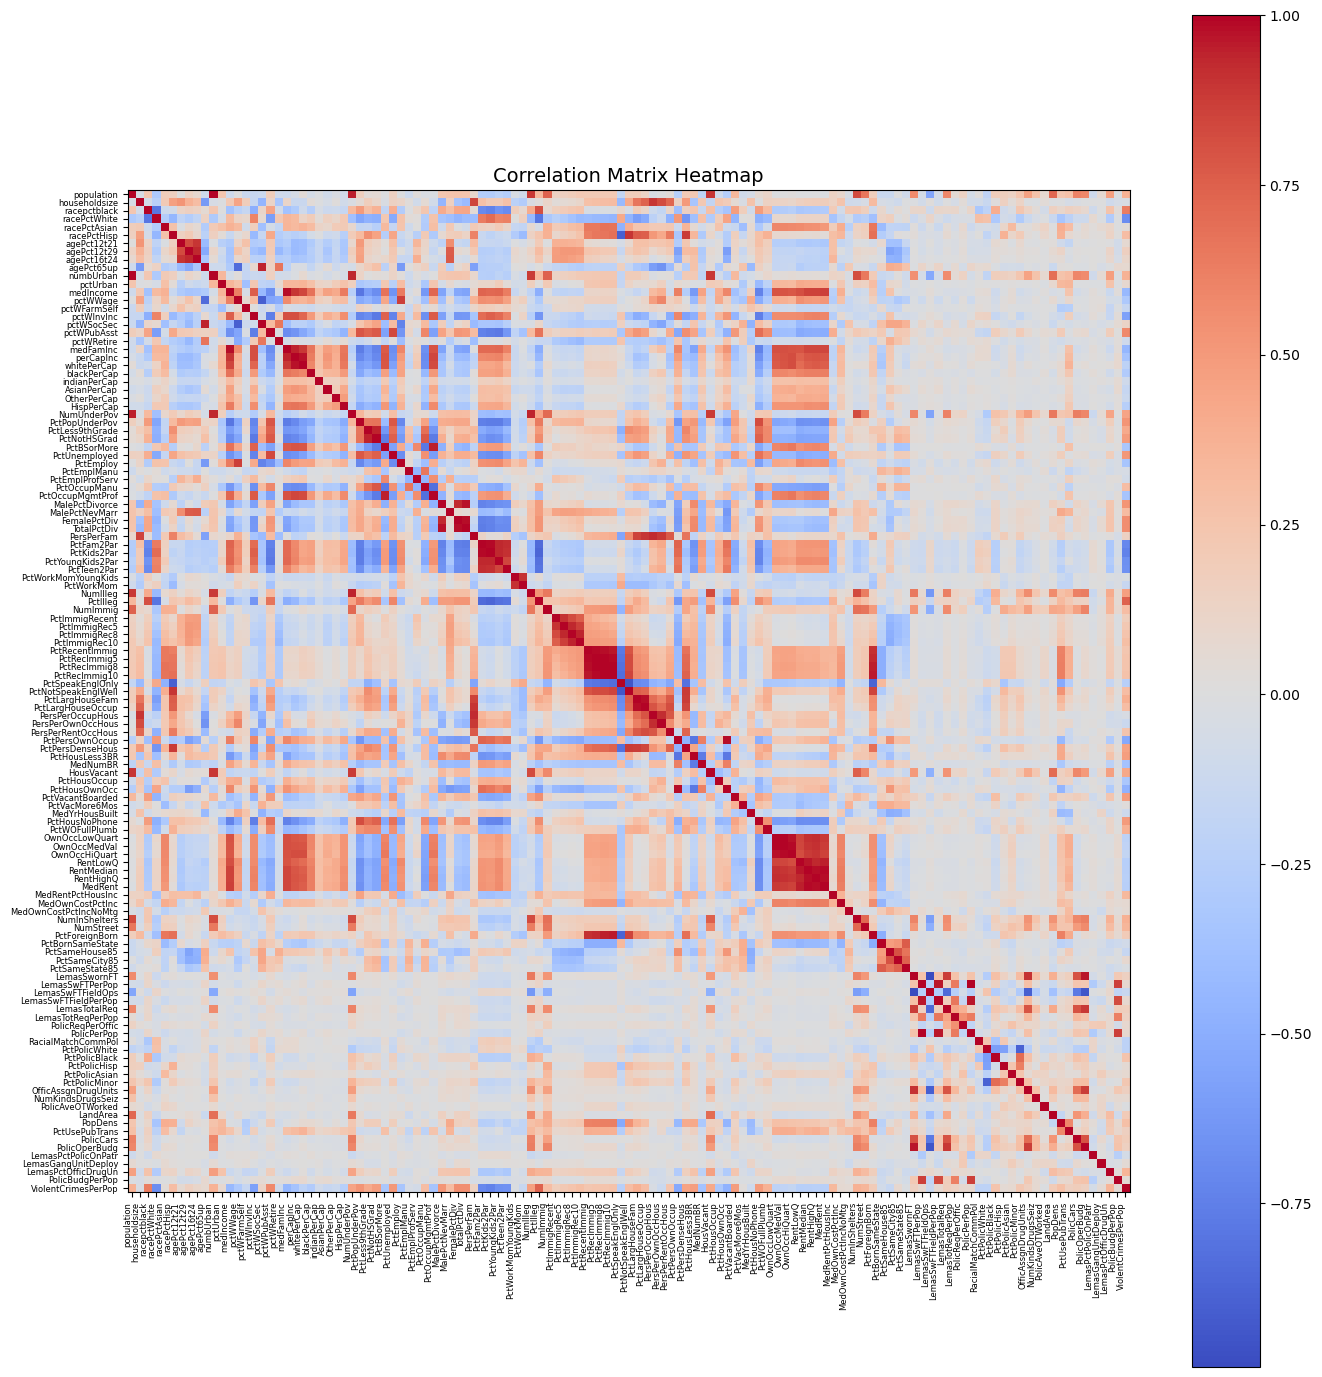

In [104]:

# computing the correlation matrix for the combined dataset
matrixCorr = combineFrame.corr()

# creating a figure and axes with specified size
dia, ax = plt.subplots(figsize=(14, 14))

cax = ax.imshow(matrixCorr, cmap='coolwarm', interpolation='none')

dia.colorbar(cax, ax=ax)

ax.set_title("Correlation Matrix Heatmap", fontsize=14)

featNumber = len(matrixCorr.columns)

# setting the x-axis tick positions and labels
ax.set_xticks(np.arange(featNumber))
ax.set_xticklabels(matrixCorr.columns, rotation=90, ha='right', fontsize=6)

ax.set_yticks(np.arange(featNumber))
ax.set_yticklabels(matrixCorr.columns, fontsize=6)

plt.tight_layout()

plt.show()


In [105]:
matrixCorr

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
population,1.0000000000,-0.0461484072,0.2311777382,-0.3008454852,0.1816027284,0.1562178039,0.0063675936,0.1303438913,0.0755960130,-0.1020055359,...,0.7136524854,0.2318974318,0.2703555285,0.6069423371,0.5806912448,-0.0980597596,0.0612132260,0.4663522939,-0.0213299510,0.3671573783
householdsize,-0.0461484072,1.0000000000,-0.0671091367,-0.2359069237,0.2019963651,0.4686592838,0.5204614827,0.3673384262,0.2952251551,-0.6126661138,...,-0.0150779659,-0.0040717309,-0.0515055662,-0.0322763716,-0.0050057524,0.0000133458,0.0024046583,-0.0943675224,-0.0570462488,-0.0349225953
racepctblack,0.2311777382,-0.0671091367,1.0000000000,-0.7943890393,-0.1067376760,-0.0665806639,0.1223384180,0.1534745211,0.1340679800,0.0529336749,...,0.1497582384,0.0950532056,0.1470229852,0.1210064088,0.0764196141,-0.0993000260,0.0039655026,0.2607926432,0.0287652872,0.6312636347
racePctWhite,-0.3008454852,-0.2359069237,-0.7943890393,1.0000000000,-0.2702655744,-0.4441661248,-0.1940148814,-0.2668519355,-0.1838044085,0.1364828143,...,-0.1313892000,-0.3374575877,-0.2156355527,-0.1080996901,-0.1075571594,0.0709679816,-0.0256241329,-0.2762342104,-0.0133739915,-0.6847695763
racePctAsian,0.1816027284,0.2019963651,-0.1067376760,-0.2702655744,1.0000000000,0.2667426632,-0.0250199050,0.1007274204,0.0527611999,-0.2720195755,...,-0.0010839691,0.3899437603,0.2969206674,-0.0184258330,0.0648289976,0.0251046451,0.0623853884,0.1018877576,-0.0088058295,0.0376217868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LemasPctPolicOnPatr,-0.0980597596,0.0000133458,-0.0993000260,0.0709679816,0.0251046451,0.0155769814,0.0012929567,0.0059643153,0.0088132414,0.0068623102,...,-0.0912693703,0.0395954336,0.0069468295,-0.1148957270,-0.0879981874,1.0000000000,0.0087656534,-0.0344520121,-0.2382083863,-0.0625114285
LemasGangUnitDeploy,0.0612132260,0.0024046583,0.0039655026,-0.0256241329,0.0623853884,0.0222949097,0.0115358042,0.0020776901,-0.0030259221,-0.0422100018,...,0.0998831835,-0.0833051860,-0.0897969237,0.0785054275,0.0239765742,0.0087656534,1.0000000000,-0.0389193149,-0.0217104975,0.0451665949
LemasPctOfficDrugUn,0.4663522939,-0.0943675224,0.2607926432,-0.2762342104,0.1018877576,0.1253530421,0.0013011593,0.1172902796,0.0831795937,-0.0101679775,...,0.2996318924,0.2280839847,0.2066439285,-0.0557666843,-0.0849293679,-0.0344520121,-0.0389193149,1.0000000000,0.0402580500,0.3486272580
PolicBudgPerPop,-0.0213299510,-0.0570462488,0.0287652872,-0.0133739915,-0.0088058295,0.0056344060,-0.0768161690,-0.0657006526,-0.0479761980,0.0760686965,...,-0.1039051274,0.0734152995,0.0864054966,0.2453694687,0.2585888209,-0.2382083863,-0.0217104975,0.0402580500,1.0000000000,0.0546275887


### (d) Calculate the Coefficient of Variation CV

In [107]:
# calculating the sample mean for each numeric column
meanCol = combineFrame.mean(numeric_only=True)

# calculating the sample standard deviation for each numeric column
stdsCol = combineFrame.std(numeric_only=True)

# computing the coefficient of variation for each column
varCoefficient = stdsCol / meanCol

print(varCoefficient)


population             2.2035025364
householdsize          0.3532983019
racepctblack           1.4109203964
racePctWhite           0.3237815625
racePctAsian           1.3591621938
                           ...     
LemasPctPolicOnPatr    0.1204712258
LemasGangUnitDeploy    0.3602993554
LemasPctOfficDrugUn    2.5552660029
PolicBudgPerPop        0.3437816103
ViolentCrimesPerPop    0.9790148021
Length: 123, dtype: float64


### (e) Scatter plots and box plots for highest CV features

Top features by CV:
NumStreet              4.4077024409
NumInShelters          3.4854812687
NumIlleg               2.9941964495
NumImmig               2.9004971639
LemasPctOfficDrugUn    2.5552660029
NumUnderPov            2.3049697149
population             2.2035025364
numbUrban              2.0017436382
HousVacant             1.9587797298
LandArea               1.6780314766
racePctHisp            1.6142777917
dtype: float64


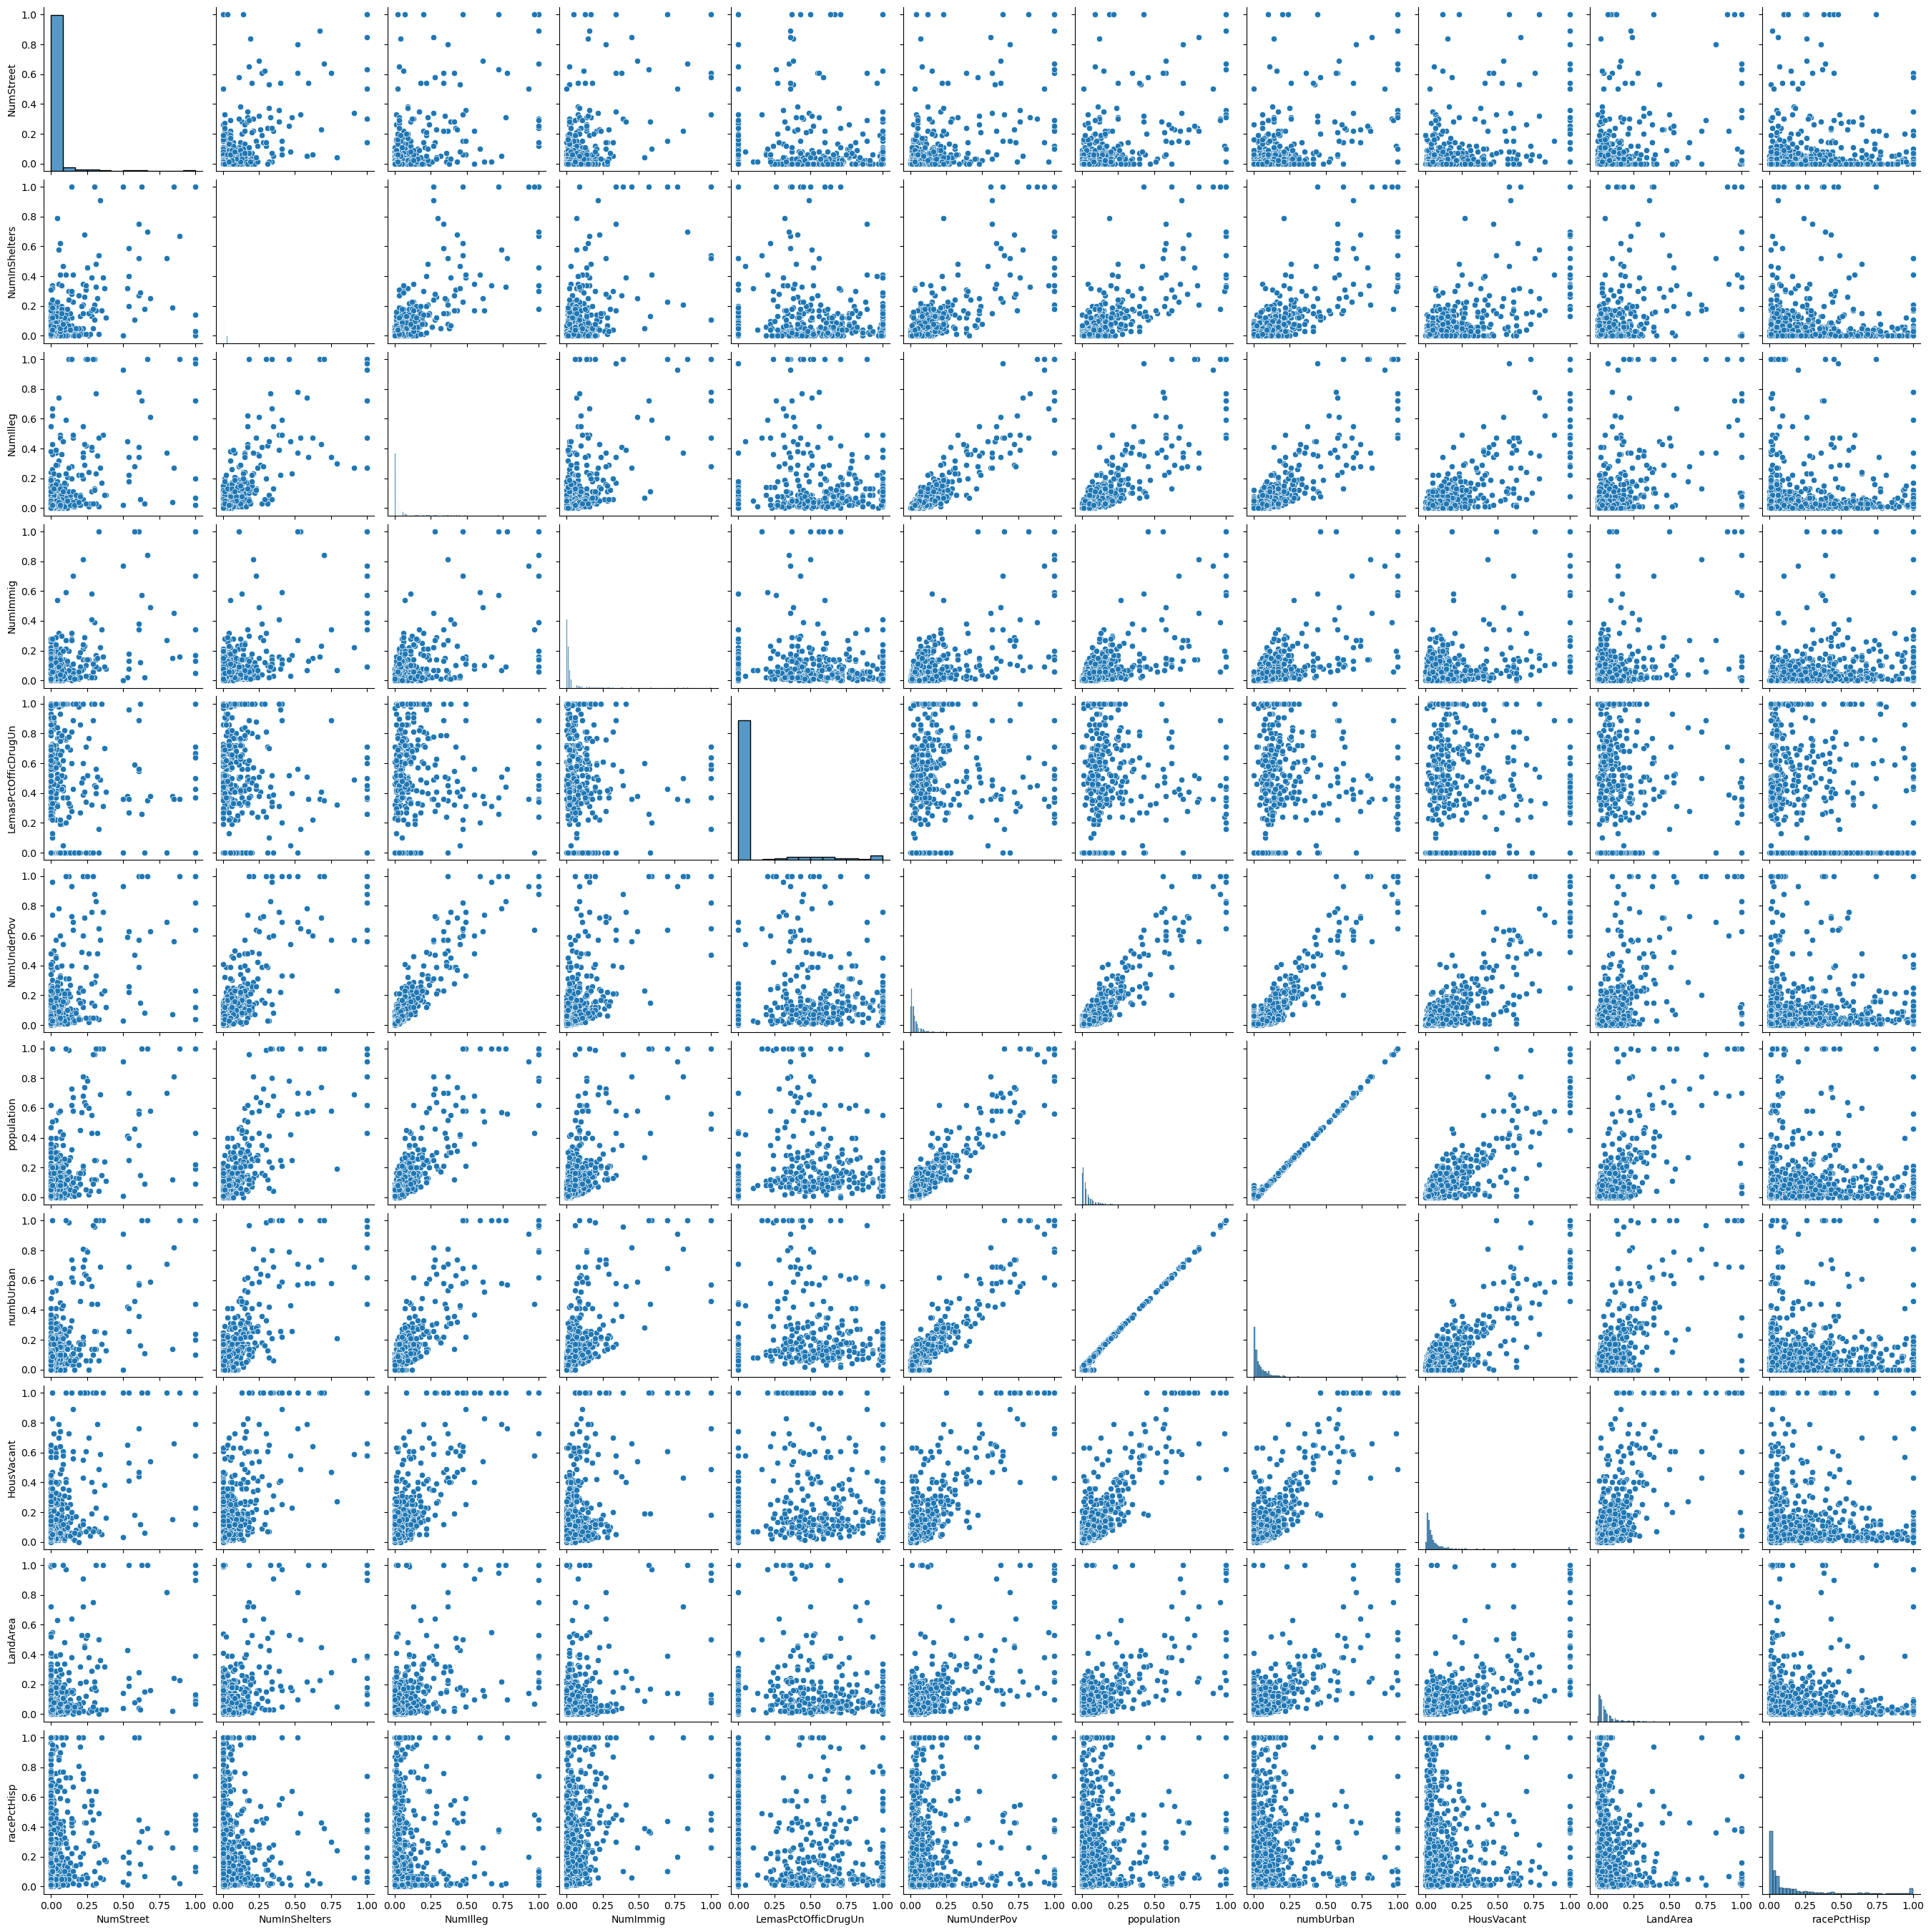

<Figure size 1400x600 with 0 Axes>

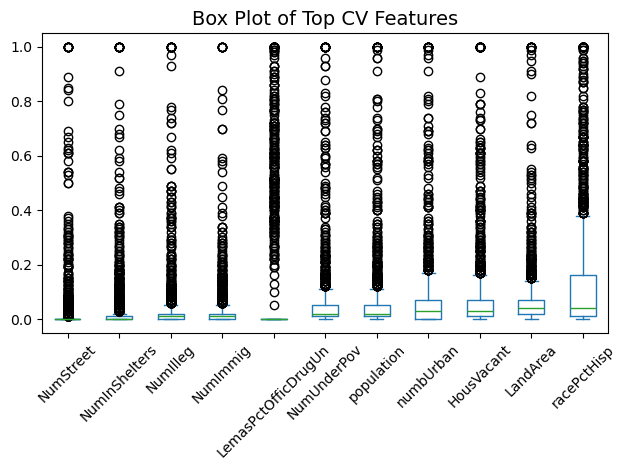

In [109]:


# calculating the number of top features to select 
featN = int(np.sqrt(128))

# selecting the top features with the highest coefficient of variation
featTopCV = varCoefficient.nlargest(featN)

print("Top features by CV:")
print(featTopCV)

sns.pairplot(combineFrame[list(featTopCV.index)])

plt.figure(figsize=(14, 6))
combineFrame[featTopCV.index].plot(kind='box', rot=45)
plt.title("Box Plot of Top CV Features", fontsize=14)
plt.tight_layout()
plt.show()


#### Can you draw conclusions about significance of those features, just by the scatter plots?  
From the scatter plots and box plots, certain features (e.g., NumStreet, LemasPctOfficDrugUn) appear to have a lower coefficient of variation, which may make them more reliable for estimation. Meanwhile, other pairs, such as Population vs. numUrban, NumUnderPov vs. numUrban, NumUnderPov vs. Population, and NumIlleg vs. NumUnderPov, show visually discernible positive correlations.
However, scatter plots alone cannot provide conclusive evidence of feature importance or statistical significance. They give an initial glimpse into relationships and trends, but more rigorous methods—like hypothesis testing, regression modeling, or additional statistical tests—are needed to confirm whether these observations hold true in a broader sense.

### (f) Fit a linear model

In [112]:


# selecting the target feature and the list of input features
targetFeat = 'ViolentCrimesPerPop'
feat = [col for col in trainFrame.columns if col != targetFeat]

X_train = trainFrame[feat]
y_train = trainFrame[targetFeat]

X_test = testFrame[feat]
y_test = testFrame[targetFeat]

# adding a constant term to the training input data
X_trainConst = sm.add_constant(X_train, has_constant='add')

# adding a constant term to the test input data
X_testConst = sm.add_constant(X_test, has_constant='add')

# fitting the ordinary least squares regression model on the training data
modelOls = sm.OLS(y_train, X_trainConst).fit()

yPred = modelOls.predict(X_testConst)

# calculating the mean squared error on the test data
mseTest = mean_squared_error(y_test, yPred)
print(" Test Error Rate is", round(mseTest, 4))

# mValue = 49


 Test Error Rate is 0.0181


### (g) Fit a ridge regression model

In [114]:
targetCol = 'ViolentCrimesPerPop'
featCols = [col for col in trainFrame.columns if col != targetCol]

X_trainSet = trainFrame[featCols]
y_trainSet = trainFrame[targetCol]
X_testSet = testFrame[featCols]
y_testSet = testFrame[targetCol]

# defining a list of alpha values to evaluate
lamdaAlphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

outputs = []

# training and evaluating a ridge regression model for each alpha
for alpha in lamdaAlphas:
    mod = Ridge(alpha=alpha)
    mod.fit(X_trainSet, y_trainSet)
    testPred = mod.predict(X_testSet)
    testMse = mean_squared_error(y_testSet, testPred)
    
    outputs.append({
        'alpha': float(alpha),
        'testMse': float(f"{testMse:.10f}")
    })

mseTestDs = pd.DataFrame(outputs)
pd.set_option('display.precision', 10)

print("\n Test MSE for each Ridge alpha (Full Precision):")
print(mseTestDs)

ridMod = Ridge()
gridPar = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

cvConfig = KFold(n_splits=5, shuffle=True, random_state=42)
searcher = GridSearchCV(ridMod, gridPar, cv=cvConfig, scoring='neg_mean_squared_error')
searcher.fit(X_trainSet, y_trainSet)

# evaluating the best model from grid search on the test data
ridBest = searcher.best_estimator_
predictedY = ridBest.predict(X_testSet)
ridMseTest = mean_squared_error(y_testSet, predictedY)

print(" Best Lambda (alpha) selected by CV:", searcher.best_params_['alpha'])
print(" Test Error (MSE) using Ridge + GridSearchCV:", round(ridMseTest, 10))




 Test MSE for each Ridge alpha (Full Precision):
      alpha       testMse
0    0.0001  0.0181415528
1    0.0010  0.0181377837
2    0.0100  0.0181034825
3    0.1000  0.0179799799
4    1.0000  0.0177324750
5   10.0000  0.0174394192
6  100.0000  0.0178923596
 Best Lambda (alpha) selected by CV: 10
 Test Error (MSE) using Ridge + GridSearchCV: 0.0174394192


### (h) Fit a LASSO model

In [116]:


# defining the target and input feature columns
resCol = 'ViolentCrimesPerPop'
predCols = [col for col in trainFrame.columns if col != resCol]

# preparing the training and testing sets
X_trainOrg = trainFrame[predCols]
y_trainOrg = trainFrame[resCol]
X_testOrg = testFrame[predCols]
y_testOrg = testFrame[resCol]

# defining a function to fit and evaluate lasso regression with optional feature scaling
def run_lasso(train_x, train_y, test_x, test_y, applyFeatScaling=False):
    
    if applyFeatScaling:
        scaler = StandardScaler()
        train_x = scaler.fit_transform(train_x)
        test_x = scaler.transform(test_x)
    else:
        train_x = train_x.values
        test_x = test_x.values

    rangeLamda = {'alpha': [9.421060424823112e-05, 0.0001, 0.00071, 0.001, 0.01, 0.1, 1, 10]}
    flds = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # performing grid search using lasso regression
    search = GridSearchCV(Lasso(max_iter=10000), rangeLamda, scoring='neg_mean_squared_error', cv=flds)
    search.fit(train_x, train_y)
    
    modBest = search.best_estimator_
    preds = modBest.predict(test_x)
    mseTest = mean_squared_error(test_y, preds)

    selected = [(name, coef) for name, coef in zip(predCols, modBest.coef_) if coef != 0]

    return search.best_params_['alpha'], mseTest, selected

# fitting lasso model without standardization
unscleLamda, unscleMse, unsclefeat = run_lasso(X_trainOrg, y_trainOrg, X_testOrg, y_testOrg, applyFeatScaling=False)

# fitting lasso model with standardization
scaleLamda, scaleMse, scaleFeat = run_lasso(X_trainOrg, y_trainOrg, X_testOrg, y_testOrg, applyFeatScaling=True)

# printing results for model without standardization
print(" Without Standardization:")
print("Optimal Lambda:", unscleLamda)
print("Test MSE:", round(unscleMse, 10))
print("Number of Selected Features:", len(unsclefeat))
for feat, coef in unsclefeat:
    print(f"{feat}: {coef}")

# printing results for model with standardization
print("\n With Standardization:")
print("Optimal Lambda:", scaleLamda)
print("Test MSE:", round(scaleMse, 10))
print("Number of Selected Features:", len(scaleFeat))
for feat, coef in scaleFeat:
    print(f"{feat}: {coef}")


 Without Standardization:
Optimal Lambda: 0.0001
Test MSE: 0.0177860895
Number of Selected Features: 78
racepctblack: 0.2730520389324694
racePctAsian: -0.017982140855571396
agePct12t21: 0.07600144588877865
agePct12t29: -0.2911250893874774
agePct65up: 0.003873181454300109
pctUrban: 0.040994608403403826
pctWWage: -0.09316409100565558
pctWFarmSelf: 0.029058209023502077
pctWInvInc: -0.11005720598186172
pctWSocSec: 0.05923780277163896
pctWPubAsst: 0.04182285101160421
pctWRetire: -0.10979717754165402
whitePerCap: -0.06946043558641395
blackPerCap: -0.022540084214983575
indianPerCap: -0.031945719112351896
AsianPerCap: 0.02923881996755525
OtherPerCap: 0.023618876027231624
HispPerCap: 0.025708960910019778
PctPopUnderPov: -0.15012475708765358
PctLess9thGrade: -0.021300485296411747
PctBSorMore: 0.017314814759812173
PctEmploy: 0.155009799866782
PctEmplManu: -0.01919700635955969
PctOccupManu: 0.016491893545625566
MalePctDivorce: 0.1326302647084667
MalePctNevMarr: 0.15069237876136446
FemalePctDiv: -0

#### Report the test error for both cases and compare them.
There is minimal difference in test error between the standardized and unstandardized versions of the data. The Lasso model gives similar results in both scenarios, though the version with standardized features results in a slightly higher test error.

### (i) Fit a PCR model

In [119]:


varTarget = 'ViolentCrimesPerPop'
varInput = trainFrame.drop(columns=[varTarget])
valTarget = trainFrame[varTarget]
varTest = testFrame.drop(columns=[varTarget])
valTestTarget = testFrame[varTarget]

configCv = KFold(n_splits=5, shuffle=True, random_state=50)
componentMse = {}

# evaluating mean squared error using cross-validation for different component counts
for k in range(1, varInput.shape[1] + 1):
    pipeMod = make_pipeline(PCA(n_components=k), LinearRegression())
    cvMse = cross_val_score(pipeMod, varInput, valTarget,
                             cv=configCv, scoring='neg_mean_squared_error')
    componentMse[k] = -cvMse.mean()

# identifying the number of components that gives the lowest training mse
kOpt = min(componentMse, key=componentMse.get)
trainBestMse = componentMse[kOpt]


print(f"Optimal number of principal components (M): {kOpt}")
print(f"Training MSE using PCR with M = {kOpt}: {trainBestMse}")

# training the final model using the optimal number of principal components
modelFin = make_pipeline(PCA(n_components=kOpt), LinearRegression())
modelFin.fit(varInput, valTarget)

# predicting the target on the test data using the trained model
predTest = modelFin.predict(varTest)
testMse = mean_squared_error(valTestTarget, predTest)

print(f"Test MSE using PCR with M = {kOpt}: {testMse}")


Optimal number of principal components (M): 94
Training MSE using PCR with M = 94: 0.01945795556416872
Test MSE using PCR with M = 94: 0.018518491833700995


### (j) Fit a boosting tree

In [121]:
#!pip install xgboost

In [122]:


# selecting the target and feature columns from the training and test data
targetCol = 'ViolentCrimesPerPop'
featCols = [col for col in trainFrame.columns if col != targetCol]

trainSetXGB = trainFrame[featCols]
trainTargetSet = trainFrame[targetCol]
testSetXGB = testFrame[featCols]
testTargetSet = testFrame[targetCol]

# initializing the xgboost regressor and defining the alpha values to search
model_boosting = XGBRegressor(random_state=50)
gridPar = {'reg_alpha': list(range(0, 11))}


cvConfig = KFold(n_splits=5, shuffle=True, random_state=50)


boostXGB = GridSearchCV(model_boosting, gridPar, scoring='neg_mean_squared_error', cv=cvConfig)
boostXGB.fit(trainSetXGB, trainTargetSet)


alphaOpt = boostXGB.best_params_['reg_alpha']
mseTrain = -boostXGB.best_score_

# evaluating the best model on the test data
modelFin = boostXGB.best_estimator_
predictions = modelFin.predict(testSetXGB)
testMse = mean_squared_error(testTargetSet, predictions)

# extracting and formatting training mse for all alpha values
cvDsResult = pd.DataFrame(boostXGB.cv_results_)
cvDsResult['mean_train_mse'] = -cvDsResult['mean_test_score']
mseTrainTable = cvDsResult[['param_reg_alpha', 'mean_train_mse']].sort_values(by='param_reg_alpha')

# setting display precision and printing the mse table
pd.set_option('display.precision', 10)
print("\n Training MSE for all reg_alpha values (via cross-validation):")
print(mseTrainTable)

# printing the best alpha, training mse, and test mse
print(" Optimal Alpha (L1 regularization) selected:", alphaOpt)
print(" Training MSE :", round(mseTrain, 10))
print(" Test MSE:", round(testMse, 10))



 Training MSE for all reg_alpha values (via cross-validation):
    param_reg_alpha  mean_train_mse
0                 0    0.0234320745
1                 1    0.0209539261
2                 2    0.0206135326
3                 3    0.0208141586
4                 4    0.0211338521
5                 5    0.0213101465
6                 6    0.0213176975
7                 7    0.0218012013
8                 8    0.0221059675
9                 9    0.0216868474
10               10    0.0225321478
 Optimal Alpha (L1 regularization) selected: 2
 Training MSE : 0.0206135326
 Test MSE: 0.0186129333


### References


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html
https://xgboost.readthedocs.io/en/stable/python/python_api/xgboost.XGBRegressor.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.best_params_
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.best_score_
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.best_estimator_
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
https://www.statsmodels.org/stable/generated/statsmodels.tools.tools.add_constant.html
https://numpy.org/doc/stable/reference/generated/numpy.sqrt.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nlargest.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
https://seaborn.pydata.org/generated/seaborn.pairplot.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.title.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
https://docs.python.org/3/library/string.html#format-specification-mini-language
https://docs.python.org/3/library/stdtypes.html#str.join
https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/tree/_tree.pxd
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.tree_
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html
https://numpy.org/doc/stable/reference/generated/numpy.isnan.html
https://numpy.org/doc/stable/reference/generated/numpy.nanmean.html
https://numpy.org/doc/stable/reference/generated/numpy.empty.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_yticklabels.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_yticks.html
https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html